In [ ]:
#importing libraries
import os
import sys 
import cv2 as cv
import numpy as np
import plotly.io as pio
import ipywidgets as widget
import plotly.graph_objs as go
import matplotlib.pyplot as plt


from PIL import Image
from skimage import color
from plotly import subplots
from random import randrange
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

import cv2 as cv
import math

import seaborn as sns
import matplotlib.pyplot as plt

# #setting the rederer as colab
# pio.renderers.default = "colab"

In [ ]:
# path to images

def input_images(path):

  X = []
  X_flat = []

  size = 64

  # iterate through images
  for img in os.listdir(path):

      # read and grayscale image
      img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
      
      # form matrix of an image
      img_pil = Image.fromarray(img_array)

      # resize image
      img_64x64 = np.array(img_pil.resize((size, size)))

      X.append(img_64x64)

      # flatten the image
      img_array = img_64x64.flatten()

      X_flat.append(img_array)

  # convert to numpy array
  X_flat = np.asarray(X_flat)

  # images as columns
  X_flat = X_flat.T

  return X, X_flat

In [ ]:
path_class_yes = "brain_tumor_dataset/yes/"
path_class_no = "brain_tumor_dataset/no/"


In [ ]:
def filter_gaussian(img, kernel_size=(3, 3)):
  img_gaussian = cv.GaussianBlur(img, (3, 3), 0)
  return img_gaussian

In [ ]:
def detector_marr_hildreth(img, sigma=1.5):
  # contributor https://github.com/adl1995/edge-detectors
  """
          finds the edges using MarrHildreth edge detection method...
          :param im : input image
          :param sigma : sigma is the std-deviation and refers to the spread of gaussian
          :return:
          a binary edge image
  """
  # gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  size = int(2*(np.ceil(3*sigma))+1)
  x, y = np.meshgrid(np.arange(-size/2+1, size/2+1),
                      np.arange(-size/2+1, size/2+1))
  normal = 1 / (2.0 * np.pi * sigma**2)
  kernel = ((x**2 + y**2 - (2.0*sigma**2)) / sigma**4) * \
      np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal  # LoG filter
  kern_size = kernel.shape[0]
  log = np.zeros_like(img, dtype=float)
  # applying filter
  for i in range(img.shape[0]-(kern_size-1)):
      for j in range(img.shape[1]-(kern_size-1)):
          window = img[i:i+kern_size, j:j+kern_size] * kernel
          log[i, j] = np.sum(window)
  log = log.astype(np.int64, copy=False)
  zero_crossing = np.zeros_like(log)
  # computing zero crossing
  for i in range(log.shape[0]-(kern_size-1)):
      for j in range(log.shape[1]-(kern_size-1)):
          if log[i][j] == 0:
              if (log[i][j-1] < 0 and log[i][j+1] > 0) or (log[i][j-1] < 0 and log[i][j+1] < 0) or (log[i-1][j] < 0 and log[i+1][j] > 0) or (log[i-1][j] > 0 and log[i+1][j] < 0):
                  zero_crossing[i][j] = 255
          if log[i][j] < 0:
              if (log[i][j-1] > 0) or (log[i][j+1] > 0) or (log[i-1][j] > 0) or (log[i+1][j] > 0):
                  zero_crossing[i][j] = 255
  return zero_crossing


Accuracy of KNN is %31.57894736842105


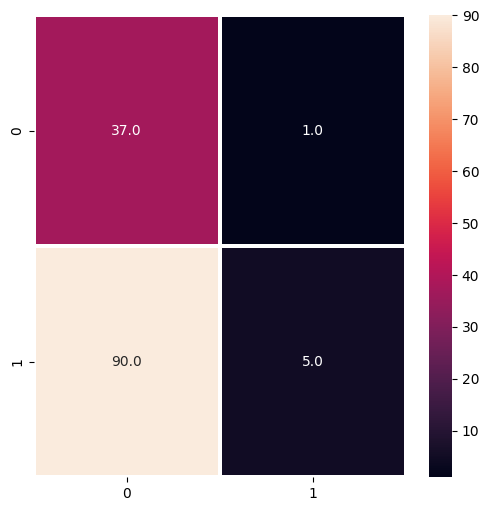

In [ ]:
def image_preprocessing(path_class_yes, path_class_no):

  X_yes, X_flat_yes = input_images(path_class_yes)
  X_no, X_flat_no = input_images(path_class_no)

  X_flat_yes = X_flat_yes.T
  X_flat_no = X_flat_no.T

  X_train_yes = X_flat_yes[:60].T
  X_test_yes = X_flat_yes[60:].T
  X_train_no = X_flat_no[:60].T
  X_test_no = X_flat_no[60:].T

  # combine classes
  X_flat_yes_no_train = np.concatenate((X_train_yes.T, X_train_no.T)).T
  X_flat_yes_no_test = np.concatenate((X_test_yes.T, X_test_no.T)).T

  y_train = np.concatenate((np.ones(60), np.zeros(60)))
  y_test = np.concatenate((np.ones(155-60), np.zeros(98-60))) 

  # apply filters
  gaussian_filter_applied = filter_gaussian(X_flat_yes_no_train)
  gaussian_filter_applied_test = filter_gaussian(X_flat_yes_no_test)

  # apply edge detectors
  marr_hilberth_edge_detector_applies = detector_marr_hildreth(gaussian_filter_applied)
  marr_hilberth_edge_detector_applies_test = detector_marr_hildreth(gaussian_filter_applied_test)

  processed_train = marr_hilberth_edge_detector_applies
  processed_test = marr_hilberth_edge_detector_applies_test

  clf = KNeighborsClassifier()
    
  clf.fit(processed_train.T,y_train)

  y_pred = clf.predict(processed_test.T)
  
  print("Accuracy of KNN is %{}".format(accuracy_score(y_pred=y_pred,y_true=y_test)*100))
    
  confmatrix = confusion_matrix(y_pred=y_pred,y_true=y_test)
    
  plt.subplots(figsize=(6,6))
  sns.heatmap(confmatrix,annot=True,fmt=".1f",linewidths=1.5)

image_preprocessing(path_class_yes, path_class_no)
